In [1]:
import sys
import os

os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"]= "expandable_segments:True"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
# torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
import readline
import scipy.sparse
import scipy
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras_core.models import Sequential
from keras_core.layers import Input, Dense, Dropout, Activation
from keras_core.optimizers import RMSprop, Adam, Nadam, Adamax
from keras_core.models import model_from_json
# import sklearn.external.joblib as extjoblib
import joblib

Using PyTorch backend.


In [3]:
# Import the 'LIKES' from the training dataset and process
###############
likes = pd.read_csv("/home/jamster/old-repos/ml2018-projectDATA/tcss555/training/relation/relation.csv")

In [4]:
# likes.head()

In [5]:
likes.columns

Index(['Unnamed: 0', 'userid', 'like_id'], dtype='object')

In [6]:
# Extact individual columns and convert to lists
likesUIDs = likes['userid'].values
likesLIDs = likes['like_id'].values
lsLikesUIDs = likesUIDs.tolist()
lsLikesLIDs = likesLIDs.tolist()

In [7]:
# Convert columns to sets
setLikesUIDs = set(lsLikesUIDs)
setLikesLIDs = set(lsLikesLIDs)

In [8]:
# Convert columns to list of unique items
unqLikesUIDs = (list(setLikesUIDs))
unqLikesLIDs = (list(setLikesLIDs))

In [9]:
# Get list of all User IDs (UIDs) paried with the Like IDs (LIDs) of the 
#   posts the user has liked
allLikesLS = [lsLikesUIDs, [str(x) for x in lsLikesLIDs]]
allLikesLS = list(map(list, zip(*allLikesLS)))

In [10]:
# Convert list of UID and LID pairs into a dictionary indexed by UIDs
aDictLikes2 = {}
for aUID in unqLikesUIDs:
	aDictLikes2[aUID]=[]

for row in allLikesLS:
	aDictLikes2[row[0]].append(row[1])

In [11]:
# Convert into a dictionary (by UIDs) of dictionaries (by LIDs)
combDICT = {}
for uid in unqLikesUIDs:
	tmpDICT={}
	tmpLS = aDictLikes2[uid]
	for row in tmpLS:
		tmpDICT[str(row)]=1
	combDICT[uid]=tmpDICT

In [12]:
# Convert 'combDICT' into a list of dictionaries (of LIDs)
tryTHIS=[]
for uid in unqLikesUIDs:
	tryTHIS.append(combDICT[uid])

In [13]:
# Vectorize the list of dictionaries in 'tryTHIS' to get the UID/LID matrix 
#   for the training data
v = DictVectorizer()
likesMAT=v.fit_transform(tryTHIS)

In [14]:
# Clear unused variable to free memory
del globals()['likes']
del globals()['likesUIDs']
del globals()['likesLIDs']
del globals()['lsLikesUIDs']
del globals()['lsLikesLIDs']
del globals()['setLikesUIDs']
del globals()['setLikesLIDs']
del globals()['allLikesLS']
del globals()['aDictLikes2']
del globals()['aUID']
del globals()['row']
del globals()['combDICT']
del globals()['uid']
del globals()['tmpDICT']
del globals()['tmpLS']
del globals()['tryTHIS']
del globals()['v']

In [15]:
# Import the profiles from the training dataset
###############
profilesDF=pd.read_csv("/home/jamster/old-repos/ml2018-projectDATA/tcss555/training/profile/profile.csv")

# profilesDF.head()

In [16]:
profilesDF.columns

Index(['Unnamed: 0', 'userid', 'age', 'gender', 'ope', 'con', 'ext', 'agr',
       'neu'],
      dtype='object')

In [17]:
# Get the values of the relevant columns and convert them to a list
profiles=profilesDF[['userid', 'age', 'gender', 'ope', 'con', 'ext', 'agr', 'neu']].values.copy()
profilesLSo=profiles.tolist().copy()

In [18]:
# Categorize the ages
profilesLS=[]
for row in profilesLSo:
	tmpLS=row
	tmpAGE=row[1]

	if tmpAGE < 25:
		tmpLS[1]=1
	elif tmpAGE < 35:
		tmpLS[1]=2
	elif tmpAGE < 50:
		tmpLS[1]=3
	else:
		tmpLS[1]=4

	profilesLS.append(tmpLS)

In [19]:
# Align the profiles data with the indexing of the likes data
profsTOlikes=[]
for i in range(len(profilesLS)):
	profsTOlikes.append([])

for row in profilesLS:
	tmpIND = unqLikesUIDs.index(row[0])
	profsTOlikes[tmpIND]=row

profsTOlikes1=list(map(list, zip(*profsTOlikes)))

In [20]:
# Extract Data for AGEs
agesARRo=np.array(profsTOlikes1[1])
agesARRo=agesARRo.tolist()

In [21]:
# Convert data for AGEs to binary vectors
agesARR = []
for row in agesARRo:
	if row==1:
		agesARR.append([1,0,0,0])
	elif row==2:
		agesARR.append([0,1,0,0])
	elif row==3:
		agesARR.append([0,0,1,0])
	else:
		agesARR.append([0,0,0,1])

agesARR=np.array(agesARR)

In [22]:
# Clear MORE unused variable to free memory
del globals()['unqLikesUIDs']
del globals()['unqLikesLIDs']
del globals()['profilesDF']
del globals()['profiles']
del globals()['profilesLSo']
del globals()['profilesLS']
del globals()['row']
del globals()['tmpLS']
del globals()['tmpAGE']
del globals()['profsTOlikes']
del globals()['i']
del globals()['tmpIND']

Need to pickle the numpy arrays

In [23]:
# import torch

torch.get_default_device()

device(type='cpu')

In [24]:
torch.device("cuda")

device(type='cuda')

In [25]:
torch.cuda.set_device="0"

In [26]:
device = torch.device('cuda')
# torch.cuda.set_device(0)
# torch.get_device()

In [27]:
from sklearn.model_selection import train_test_split

train_likesMAT, test_likesMAT, train_agesARR, test_agesARR = train_test_split(likesMAT, agesARR, test_size=0.05, random_state=42)
# train_likesMAT, test_likesMAT, train_agesARR, test_agesARR = train_test_split(likesMAT, agesARR, test_size=0.85, random_state=42)

In [28]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
import numpy as np
from scipy import linalg, sparse

In [29]:
sq_likesMAT_1 = np.dot(train_likesMAT, train_likesMAT.T)
sq_likesMAT_1.shape

(9025, 9025)

In [30]:
from torch.utils.data import TensorDataset

tensor_sq_likesMAT_1 = torch.Tensor(sq_likesMAT_1.todense()) \
                            .to(torch.float) \
                            .cuda()

In [31]:
tensor_sq_likesMAT_1_evals = torch.linalg.eig(tensor_sq_likesMAT_1)

In [32]:
sq_likesMAT_1_evals = tensor_sq_likesMAT_1_evals.eigenvalues.to(torch.float32).cpu().numpy()

del tensor_sq_likesMAT_1_evals
del tensor_sq_likesMAT_1

print(sq_likesMAT_1_evals)

[6.433316e+04 2.279608e+04 8.965205e+03 ... 2.000000e+00 4.000000e+00
 1.000000e+00]


/tmp/ipykernel_98773/3888341673.py:1: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:305.)
  sq_likesMAT_1_evals = tensor_sq_likesMAT_1_evals.eigenvalues.to(torch.float32).cpu().numpy()


In [33]:
print(np.sort(sq_likesMAT_1_evals))

[3.9693528e-01 4.2805117e-01 4.5301065e-01 ... 8.9652051e+03 2.2796080e+04
 6.4333160e+04]


In [34]:
print(np.sort(sq_likesMAT_1_evals)[8900:])

[ 1424.2222  1436.4185  1437.7374  1440.2511  1441.6886  1448.3381
  1454.7435  1464.5554  1469.1974  1474.5692  1481.4847  1487.3687
  1493.6383  1499.3894  1508.558   1514.324   1521.7627  1529.1177
  1537.638   1544.0542  1546.006   1561.2601  1575.5616  1578.5449
  1580.8926  1584.5984  1593.2631  1598.5974  1613.5791  1614.3868
  1623.559   1642.423   1648.188   1653.9132  1671.477   1677.528
  1683.7715  1688.0109  1699.5115  1708.4006  1715.9788  1721.6787
  1728.5928  1739.7432  1747.4581  1753.4513  1764.4181  1767.5985
  1774.8297  1779.5592  1791.3201  1801.45    1820.1228  1829.3396
  1852.0891  1857.4203  1869.8115  1872.7921  1888.1279  1897.2958
  1901.9084  1919.2925  1937.5717  1962.1475  1974.0154  1992.7412
  2009.3231  2015.6682  2030.4316  2040.8151  2057.2395  2065.5242
  2087.2117  2107.014   2156.35    2172.52    2176.8215  2187.4546
  2212.1738  2228.735   2257.575   2289.8752  2301.2908  2332.2092
  2352.8594  2363.6982  2379.0508  2385.1843  2418.6836  2442.2

In [35]:
sq_likesMAT_1_evals.shape

(9025,)

In [36]:
np.unique(sq_likesMAT_1_evals).shape

(8856,)

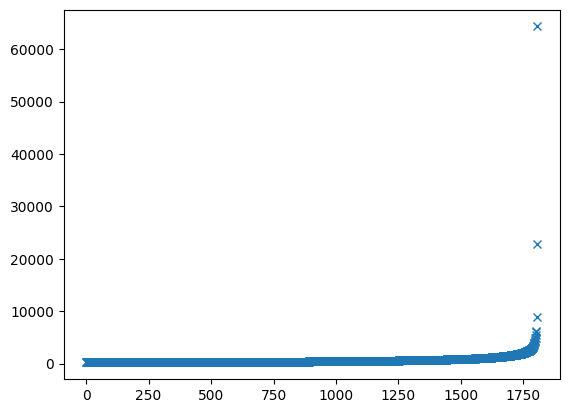

In [37]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
pp.plot(np.asarray(range(np.unique(sq_likesMAT_1_evals)[7050:].shape[0])) + val, np.sort(np.unique(sq_likesMAT_1_evals))[7050:], 'x')
pp.show()

# plt.hist(np.sort(sq_likesMAT_1_evals), bins='auto')  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
# plt.show()

In [38]:
np.sort(sq_likesMAT_1_evals)[8800]

1023.94855

### Compute to 51 eigenvalues ==> SVD

In [39]:
# linalg.eig(sq_likesMAT_1.todense())

In [45]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np

svd = TruncatedSVD(n_components=51, algorithm="arpack")
svd.fit(train_likesMAT)

TruncatedSVD(algorithm='arpack', n_components=51)

In [48]:
svd_likesMAT = svd.transform(train_likesMAT)
svd_likesMAT.shape

(9025, 51)

Delete below this

In [40]:
sq_likesMAT_2 = np.dot(train_likesMAT.T, train_likesMAT)
sq_likesMAT_2.shape

(536204, 536204)

In [41]:
from scipy.sparse.linalg import eigs

sq_likesMAT_2_evals = eigs(sq_likesMAT_2, k=1000, return_eigenvectors=False)

In [42]:
print(np.sort(sq_likesMAT_2_evals)[400:])

[  550.16463083+0.j   550.75036953+0.j   550.9088335 +0.j
   551.77100993+0.j   552.04466479+0.j   552.65734188+0.j
   553.67105667+0.j   554.54485058+0.j   555.20333537+0.j
   555.63676949+0.j   556.5089066 +0.j   556.6935497 +0.j
   557.15592212+0.j   558.52975936+0.j   559.25504509+0.j
   559.50712806+0.j   560.50021344+0.j   561.06460021+0.j
   561.13831631+0.j   562.13177508+0.j   562.25893121+0.j
   562.73863432+0.j   563.71456712+0.j   565.75783871+0.j
   566.45589786+0.j   566.97490319+0.j   567.41140167+0.j
   567.8227869 +0.j   569.19212299+0.j   569.90948298+0.j
   570.12903664+0.j   570.77579746+0.j   571.55168931+0.j
   573.04768706+0.j   573.58288375+0.j   574.21845921+0.j
   574.67669768+0.j   575.77970428+0.j   576.63056399+0.j
   577.28388682+0.j   577.66760536+0.j   578.35884138+0.j
   579.15813845+0.j   580.28574608+0.j   581.91175447+0.j
   581.99668265+0.j   583.00438155+0.j   583.6741155 +0.j
   584.41668559+0.j   585.00482556+0.j   585.18586476+0.j
   586.2086267

In [ ]:
sq_likesMAT_2_evals = linalg.eig(sq_likesMAT_2)

In [30]:
from torch.utils.data import TensorDataset

tensor_likesMAT = torch.Tensor(likesMAT.todense())#.to_sparse()
tensor_likesMAT = tensor_likesMAT.to(torch.float8_e4m3fn).cuda()

tensor_likesMAT.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.74 GiB. GPU 0 has a total capacity of 3.81 GiB of which 3.69 GiB is free. Including non-PyTorch memory, this process has 114.00 MiB memory in use. Of the allocated memory 29.19 MiB is allocated by PyTorch, and 16.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [29]:
torch.linalg.cond(tensor_likesMAT)

NotImplementedError: Could not run 'aten::_linalg_svd' with arguments from the 'SparseCUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::_linalg_svd' is only available for these backends: [CPU, CUDA, HIP, MPS, IPU, XPU, HPU, VE, MTIA, PrivateUse1, PrivateUse2, PrivateUse3, Meta, FPGA, MAIA, Vulkan, Metal, QuantizedCPU, QuantizedCUDA, QuantizedHIP, QuantizedMPS, QuantizedIPU, QuantizedXPU, QuantizedHPU, QuantizedVE, QuantizedMTIA, QuantizedPrivateUse1, QuantizedPrivateUse2, QuantizedPrivateUse3, QuantizedMeta, CustomRNGKeyId, MkldnnCPU, SparseCsrCPU, SparseCsrCUDA, SparseCsrHIP, SparseCsrMPS, SparseCsrIPU, SparseCsrXPU, SparseCsrHPU, SparseCsrVE, SparseCsrMTIA, SparseCsrPrivateUse1, SparseCsrPrivateUse2, SparseCsrPrivateUse3, SparseCsrMeta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastXPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Undefined: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
CPU: registered at aten/src/ATen/RegisterCPU.cpp:30455 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:44681 [kernel]
HIP: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
MPS: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
IPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
XPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
HPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
VE: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
MTIA: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
PrivateUse1: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
PrivateUse2: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
PrivateUse3: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
Meta: registered at /dev/null:241 [kernel]
FPGA: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
MAIA: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
Vulkan: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
Metal: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedCPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedCUDA: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedHIP: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedMPS: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedIPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedXPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedHPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedVE: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedMTIA: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedPrivateUse1: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedPrivateUse2: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedPrivateUse3: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedMeta: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
CustomRNGKeyId: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
MkldnnCPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrCPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrCUDA: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrHIP: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrMPS: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrIPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrXPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrHPU: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrVE: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrMTIA: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrPrivateUse1: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrPrivateUse2: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrPrivateUse3: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrMeta: registered at aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradHIP: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradMPS: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradIPU: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradVE: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradMTIA: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradMeta: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_4.cpp:18531 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_4.cpp:13374 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastXPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:351 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/BatchRulesLinearAlgebra.cpp:593 [kernel]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


In [29]:
from torch.utils.data import TensorDataset, DataLoader

tensor_likesMAT = torch.Tensor(likesMAT.todense()).to_sparse()
tensor_likesMAT = tensor_likesMAT.to(torch.bfloat16).cuda()

tensor_agesARR = torch.Tensor(agesARR)
tensor_agesARR = tensor_agesARR.to(torch.bool).cuda()

In [28]:
from torch.utils.data import TensorDataset, DataLoader

# tensor_likesMAT = torch.Tensor(likesMAT.todense())#.to_sparse()
# tensor_likesMAT = tensor_likesMAT.to(torch.float8_e4m3fn)
# tensor_likesMAT = tensor_likesMAT.cuda()
# tensor_agesARR = torch.Tensor(agesARR)
# tensor_agesARR = tensor_agesARR.to(torch.bool)
# tensor_agesARR = tensor_agesARR.cuda()

tensor_train_likesMAT = torch.Tensor(train_likesMAT.todense())#.to_sparse()
tensor_train_likesMAT = tensor_train_likesMAT.to(torch.torch.bfloat16)#.cuda()
tensor_test_likesMAT = torch.Tensor(test_likesMAT.todense())#.to_sparse()
tensor_test_likesMAT = tensor_test_likesMAT.to(torch.torch.bfloat16)

tensor_train_agesARR = torch.Tensor(train_agesARR)
tensor_train_agesARR = tensor_train_agesARR.to(torch.torch.bfloat16)#.cuda()
tensor_test_agesARR = torch.Tensor(test_agesARR)
tensor_test_agesARR = tensor_test_agesARR.to(torch.torch.bfloat16)

# tensor_dataset = TensorDataset(tensor_likesMAT, tensor_agesARR)
# tensor_loader = DataLoader(tensor_dataset, batch_size=128)
# tensor_loader = DataLoader(tensor_dataset, batch_size=9500)

tensor_train_dataset = TensorDataset(tensor_train_likesMAT, tensor_train_agesARR)
tensor_train_loader = DataLoader(tensor_train_dataset, batch_size=32)

tensor_test_dataset = TensorDataset(tensor_test_likesMAT, tensor_test_agesARR)
tensor_test_loader = DataLoader(tensor_test_dataset, batch_size=128)

In [29]:
print(device)

cuda


In [32]:
import torch.nn as nn
import torch.nn.functional as t_func

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(536204, 1125)
        self.drop1 = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(1125, 1500).to(device)
        self.drop2 = nn.Dropout(p=0.375).to(device)
        self.fc3 = nn.Linear(1500, 1125).to(device)
        self.drop3 = nn.Dropout(p=0.25).to(device)
        self.fc4 = nn.Linear(1125, 750).to(device)
        self.fc5 = nn.Linear(750, 4).to(device)
    def forward(self, x):
        x = self.fc1(x)
        x = t_func.relu(x)
        x = self.drop1(x)
        x = x.to(device)
        x = self.fc2(x)
        sm = nn.Softmax(dim=1)
        # x = t_func.log_softmax(x)
        x = sm(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = t_func.sigmoid(x)
        x = self.drop3(x)
        x = self.fc4(x)
        x = t_func.relu(x)
        x = self.fc5(x)
        x = sm(x)
        # x = t_func.log_softmax(x)
        return x

In [ ]:
import torch.optim as optim

network = Net()
network = network.to(torch.bfloat16)#.cuda()
optimizer = optim.Adam(network.parameters())
criterion = nn.CrossEntropyLoss()

n_epochs = 10
losses = []
counter = []

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(tensor_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs#.cuda()
        labels = labels#.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        # outputs = outputs.cuda()
        loss = criterion(outputs.to(torch.device("cpu")), labels.to(torch.device("cpu")))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [34]:
import torch.optim as optim

network = Net()
network = network.to(torch.bfloat16)#.cuda()
optimizer = optim.Adam(network.parameters())
criterion = nn.CrossEntropyLoss()

n_epochs = 10
losses = []
counter = []

def train(epoch):
    network.train()
    for batch_ind, (data, target) in enumerate(tensor_loader):
        data = data.unsqueeze(1)
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()
        if batch_ind % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%]\tLoss: {:.6f}'.format(
                epoch, batch_ind * len(data), len(tensor_loader.dataset), 
                100.0 * batch_ind / len(tensor_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_ind*64) + ((epoch-1)*len(tensor_loader.dataset)))
        

In [ ]:
for epoch in range(n_epochs+1):
    train(epoch)

In [25]:
# Training Model
###############
print("start training")

numInputs = 750 # Number of nodes to map inputs

model = Sequential()
model.add(Dense(int(numInputs*1.5),
				input_dim=int(likesMAT.shape[1]),
				activation='relu'))
model.add(Dropout(0.25))
model.add(Dense((numInputs*2),
				activation='softmax'))
model.add(Dropout(0.375))
model.add(Dense(int(numInputs*1.5),
				activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(numInputs,
				activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
				loss='categorical_crossentropy',
				metrics=['accuracy', 'mse'])

model.fit(likesMAT, agesARR, epochs=10)

print("end training")

start training


/home/jamster/keras_torch/lib/python3.11/site-packages/keras_core/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-29 18:09:35.214514: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 18:09:35.400420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 18:09:35.490235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to regis

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/home/jamster/keras_torch/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/jamster/keras_torch/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/jamster/keras_torch/lib/p

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/home/jamster/keras_torch/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/jamster/keras_torch/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/jamster/keras_torch/lib/p

AttributeError: _ARRAY_API not found

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception